In [19]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib as plt
from itertools import chain
import ast

In [20]:
df = pd.read_csv("full_set.csv")
df.shape

(588793, 31)

In [21]:
TARGET_CLASS = "CHM2210"

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]

display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

from sklearn.model_selection import train_test_split

train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 0:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

C:\Users\judem\AppData\Local\Temp\ipykernel_40356\2545726050.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
C:\Users\judem\AppData\Local\Temp\ipykernel_40356\2545726050.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x))

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester,Target_Points,Target_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


(9424, 1433) (1178, 1433) (1179, 1433)


In [22]:
groupped_df

,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,Target_Grade,Target_Points,One_Hot_Classes
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,1096567,3.85,1340.0,"[A-, A-, B-, W, A+, D, B, A+, B+, B, A, A+, A-...","[3.67, 3.67, 2.67, 0.0, 4.0, 1.0, 3.0, 4.0, 3....","[MAC1147, ENC1102, CHM2045, CHM2045L, SLS2901,...","[82970.0, 89553.0, 92762.0, 92839.0, 93253.0, ...",C,2.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,1302110,2.43,1040.0,[A],[4.0],[PCB3063],[54321.0],A+,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...
11776,3873128,3.88,1190.0,"[B+, B, A, B, A+, A]","[3.33, 3.0, 4.0, 3.0, 4.0, 4.0]","[PSY3213, BSC2010, BSC2010L, CHM2046, MHS3063,...","[80378.0, 81087.0, 81825.0, 82555.0, 83207.0, ...",B+,3.33,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11777,3877042,4.08,1180.0,"[B, A+, A, A, B, W, A+, A, A, D]","[3.0, 4.0, 4.0, 4.0, 3.0, 0.0, 4.0, 4.0, 4.0, ...","[HSC4537, CHM2046, BSC2086, BSC2086L, PCB3023L...","[82097.0, 82555.0, 83986.0, 83987.0, 10655.0, ...",B+,3.33,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11778,3878121,3.65,1370.0,"[A, A, A+]","[4.0, 4.0, 4.0]","[HSC4537, HSC4631, ENC1102]","[82097.0, 82314.0, 88675.0]",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11779,3879752,3.92,1340.0,"[B+, B-, C+]","[3.33, 2.67, 2.33]","[PCB3063, BSC3312, MAC2241]","[81419.0, 85547.0, 86259.0]",C+,2.33,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [23]:
# Create pass/fail column
def map_pass_fail(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']
    return 0 if grade in fail_grades else 1  # 0 = fail, 1 = pass

#Add columns fro grouped_df
groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(train_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
train_set = train_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(dev_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
dev_set = dev_set.join(groupped_df_filtered[add_columns], )

# Apply the function to create pass/fail column
train_set['pass_fail'] = train_set['Target_Grade'].apply(map_pass_fail)
dev_set['pass_fail'] = dev_set['Target_Grade'].apply(map_pass_fail)

# # Drop irrelevant columns
X = train_set.drop(columns=['Target_Grade', 'pass_fail'])
X_dev = dev_set.drop(columns=['Target_Grade', 'pass_fail'])

# Convert all remaining object columns to numeric
# X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()
X_dev = X_dev.dropna()

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, 'pass_fail']
y_dev = dev_set.loc[X_dev.index, 'pass_fail']

In [24]:
counts = train_set['pass_fail'].value_counts()
counts.get(1, 1)
print(counts.get(0, 0))
print(counts.get(1, 1))

1122
8302


In [25]:
train_set

ACG2021  ACG2071  ACG3074  ACG3103  ACG3341  ADV2214  ADV3008  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFA2000  AFA2380  AFA3110  AFA4150  AFA4335  AFA4430  AFA4931  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFH3100  AFH3200  AFR1101  AFR1120  AFR2001  AFR2130  AFR2140  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFR3220  AFR3231  AFR4201  AFS2250  AMH2010  AMH2020  AMH3140  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0      4.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AMH3160  AMH3170  AMH3270  AMH3403  AMH3421  AMH3423  AMH3533  \
Pidm                                                                     
706382   

In [26]:
from sklearn.utils import resample
# Apply undersampling to balance the classes
# Separate the pass and fail instances
pfcounts = train_set['pass_fail'].value_counts()
sample_count = min(counts.get(0, 0), counts.get(1, 1))

pass_class = X[y == 1]
fail_class = X[y == 0]

pass_sample = resample(pass_class, replace=False, n_samples=sample_count, random_state=50)
fail_sample = resample(fail_class, replace=False, n_samples=sample_count, random_state=50)

# Combine the undersampled data
X_undersampled = pd.concat([pass_sample, fail_sample])
y_undersampled = pd.concat([y[pass_sample.index], y[fail_sample.index]])

In [9]:
print(counts.get(0, 0))
print(counts.get(1, 1))
print(sample_count)
display(pass_sample)
display(fail_sample)

1122
8302
1122


ACG2021  ACG2071  ACG3074  ACG3103  ACG3341  ADV2214  ADV3008  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0      4.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFA2000  AFA2380  AFA3110  AFA4150  AFA4335  AFA4430  AFA4931  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFH3100  AFH3200  AFR1101  AFR1120  AFR2001  AFR2130  AFR2140  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFR3220  AFR3231  AFR4201  AFS2250  AMH2010  AMH2020  AMH3140  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AMH3160  AMH3170  AMH3270  AMH3403  AMH3421  AMH3423  AMH3533  \
Pidm                                                                     
3570131  

ACG2021  ACG2071  ACG3074  ACG3103  ACG3341  ADV2214  ADV3008  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFA2000  AFA2380  AFA3110  AFA4150  AFA4335  AFA4430  AFA4931  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFH3100  AFH3200  AFR1101  AFR1120  AFR2001  AFR2130  AFR2140  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFR3220  AFR3231  AFR4201  AFS2250  AMH2010  AMH2020  AMH3140  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AMH3160  AMH3170  AMH3270  AMH3403  AMH3421  AMH3423  AMH3533  \
Pidm                                                                     
3506043  

In [10]:


from sklearn.model_selection import GridSearchCV
import xgboost as xgb

X_train = X_undersampled
y_train = y_undersampled
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],  # Try different learning rates
    'max_depth': [3, 6, 9],             # Try different tree depths
    'n_estimators': [100, 300, 500],     # Number of boosting rounds
    'subsample': [0.8, 1.0],            # Subsample ratio
    'colsample_bytree': [0.8, 1.0]      # Column sampling
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.77
Accuracy: 0.75
Confusion Matrix:
[[181  49]
 [ 62 157]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77       230
           1       0.76      0.72      0.74       219

    accuracy                           0.75       449
   macro avg       0.75      0.75      0.75       449
weighted avg       0.75      0.75      0.75       449



Feature Importances (sorted):
       Feature  Importance
0      CHM2046    0.117454
1      CHM2045    0.044698
2      PCB3063    0.023111
3      BSC2011    0.022340
4     BSC2010L    0.021871
...        ...         ...
1430  ZOO4307L    0.000000
1431   ZOO4454    0.000000
1432   ZOO4512    0.000000
1433   ZOO4513    0.000000
1434   ZOO4694    0.000000

[1435 rows x 2 columns]


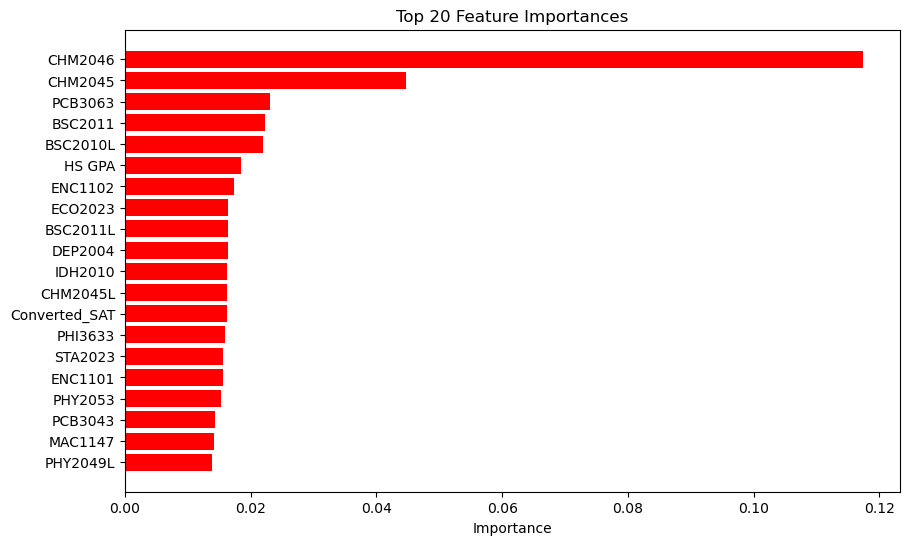

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [13]:
X_train = X_undersampled
y_train = y_undersampled
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

dt_classifier = DecisionTreeClassifier(random_state=50)

param_grid = {
    'criterion': ['gini', 'entropy'],  # Try different split criteria
    'max_depth': [3, 6, 9, None],      # Try different tree depths, including no limit
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider for the best split
}
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.74
Accuracy: 0.74
Confusion Matrix:
[[188  42]
 [ 75 144]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       230
           1       0.77      0.66      0.71       219

    accuracy                           0.74       449
   macro avg       0.74      0.74      0.74       449
weighted avg       0.74      0.74      0.74       449



Feature Importances (sorted):
            Feature  Importance
0           CHM2046    0.967374
1           IDS2378    0.014863
2           AMH2020    0.012171
3           PSY2012    0.005592
4           ACG2021    0.000000
...             ...         ...
1430        ZOO4512    0.000000
1431        ZOO4513    0.000000
1432        ZOO4694    0.000000
1433         HS GPA    0.000000
1434  Converted_SAT    0.000000

[1435 rows x 2 columns]


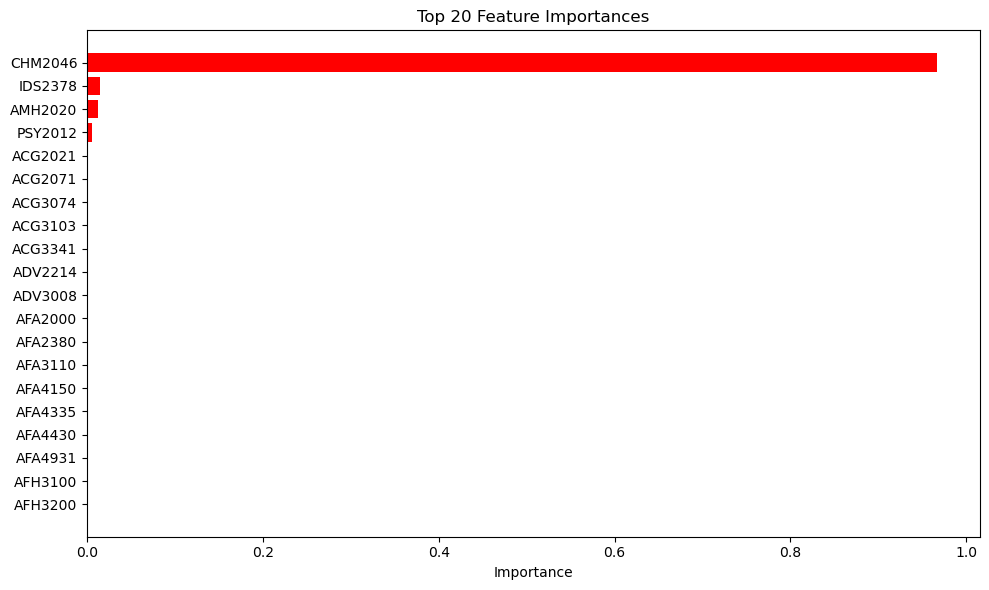

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

feature_importances = best_model.feature_importances_

feature_names = X_train.columns

feature_importance_dict = dict(zip(feature_names, feature_importances))

sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

print("Feature Importances (sorted):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

X_train = X_undersampled
X_test = X_dev
y_train = y_undersampled
y_test = y_dev

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],  # Try different learning rates
    'max_depth': [3, 6, 9],             # Try different tree depths
    'n_estimators': [100, 300, 500],     # Number of boosting rounds
    'subsample': [0.8, 1.0],            # Subsample ratio
    'colsample_bytree': [0.8, 1.0]      # Column sampling
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.76
Accuracy: 0.71
Confusion Matrix:
[[119  33]
 [303 723]]
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.78      0.41       152
           1       0.96      0.70      0.81      1026

    accuracy                           0.71      1178
   macro avg       0.62      0.74      0.61      1178
weighted avg       0.87      0.71      0.76      1178



Feature Importances (sorted):
       Feature  Importance
0      CHM2046    0.100378
1      CHM2045    0.021185
2      PCB3063    0.016063
3      BSC2011    0.012893
4      IDH3350    0.012716
...        ...         ...
1430  ZOO4307L    0.000000
1431   ZOO4454    0.000000
1432   ZOO4512    0.000000
1433   ZOO4513    0.000000
1434   ZOO4694    0.000000

[1435 rows x 2 columns]


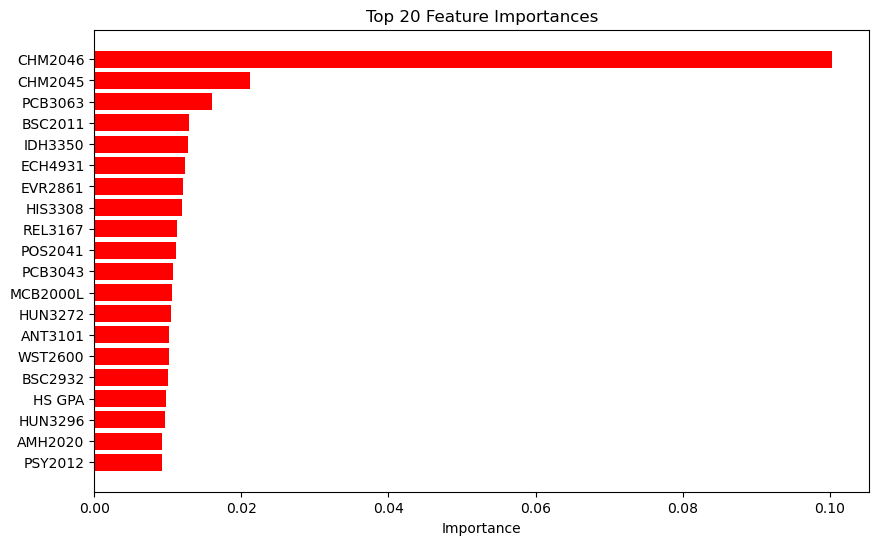

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the  classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Feature Correlations (sorted):
            Feature  Correlation  Absolute Correlation
228         CHM2046     0.327816              0.327816
1434  Converted_SAT     0.306982              0.306982
1433         HS GPA     0.283726              0.283726
706         IDH2010     0.244892              0.244892
226         CHM2045     0.199243              0.199243
...             ...          ...                   ...
1428       ZOO4307L          NaN                   NaN
1429        ZOO4454          NaN                   NaN
1430        ZOO4512          NaN                   NaN
1431        ZOO4513          NaN                   NaN
1432        ZOO4694          NaN                   NaN

[1435 rows x 3 columns]


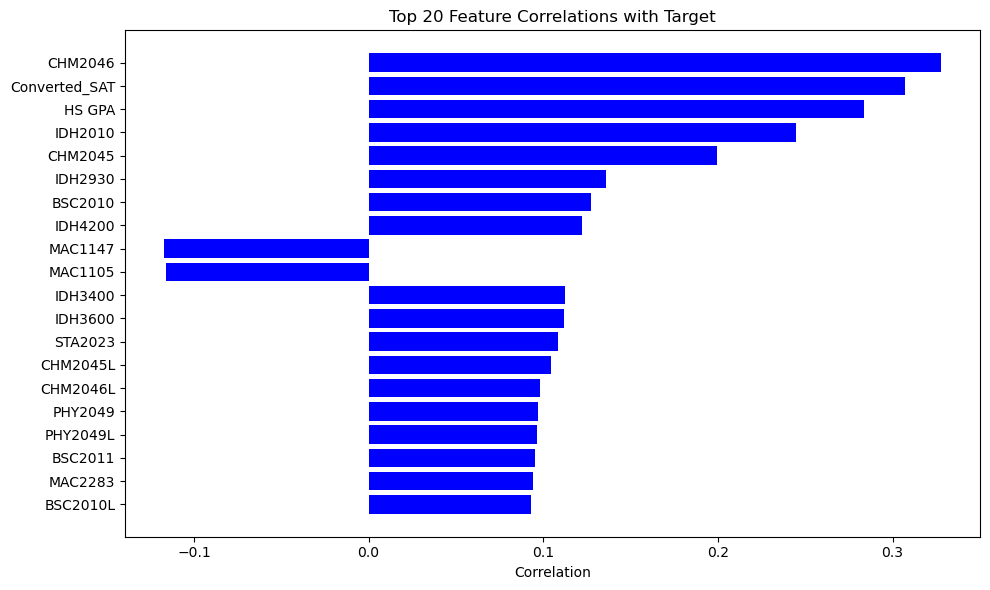

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming X_train is your features DataFrame and y_train is the target series
# Replace these with your actual data
# X_train: DataFrame containing feature columns
# y_train: Series containing the target variable

# Calculate the correlation between each feature in X_train and the target variable y_train
correlations = X_train.corrwith(y_train)

# Convert the correlations to a DataFrame for sorting and display
correlation_df = correlations.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

# Sort the features by absolute correlation in descending order
correlation_df['Absolute Correlation'] = correlation_df['Correlation'].abs()
sorted_correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)

# Display the sorted correlations as a DataFrame
print("Feature Correlations (sorted):")
print(sorted_correlation_df)

# Plotting the top 20 features for visualization (adjust if fewer features are available)
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Correlations with Target")
top_features = sorted_correlation_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Correlation'], color='b')
plt.xlabel("Correlation")
plt.gca().invert_yaxis()  # To display the highest correlation at the top
plt.tight_layout()
plt.show()